In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from scipy.optimize import minimize
import os

# STEP 0: Load Dataset


path = kagglehub.dataset_download("shrutibhargava94/india-air-quality-data")
print("Dataset path:", path)

# List contents of the directory to find the correct CSV path
print("Contents of dataset path:", os.listdir(path))

# Load CSV (adjust name if needed)
df = pd.read_csv(f"{path}/data.csv", encoding='latin1')

# --- Debugging: Print column names to identify correct NO2 column ---
print("DataFrame columns:", df.columns)

# Use NO2 feature
x = df["no2"].dropna().values




100%|██████████| 5.22M/5.22M [00:00<00:00, 154MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/shrutibhargava94/india-air-quality-data/versions/1
Contents of dataset path: ['data.csv']
DataFrame columns: Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')


/tmp/ipython-input-642754793.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{path}/data.csv", encoding='latin1')


In [ ]:
# STEP 1: Roll-number-based Transformation


r = 102303830

a_r = 0.05 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

z = x + a_r * np.sin(b_r * x)

In [ ]:

# STEP 2: MLE for λ and μ (accurate)


def negative_log_likelihood(params, z):
    lam, mu = params

    if lam <= 0:
        return np.inf

    c = np.sqrt(lam / np.pi)
    pdf = c * np.exp(-lam * (z - mu) ** 2)
    pdf = np.clip(pdf, 1e-12, None)

    return -np.sum(np.log(pdf))

# Initial guesses
init_params = [0.1, np.mean(z)]

# Optimization
result = minimize(
    negative_log_likelihood,
    init_params,
    args=(z,),
    method="L-BFGS-B",
    bounds=[(1e-6, None), (None, None)]
)

lambda_hat, mu_hat = result.x
c_hat = np.sqrt(lambda_hat / np.pi)

# ================================
# STEP 3: Output Parameters
# ================================

print("\nEstimated Parameters (Most Accurate):")
print(f"λ (lambda) = {lambda_hat:.6f}")
print(f"μ (mu)     = {mu_hat:.6f}")
print(f"c          = {c_hat:.6f}")



Estimated Parameters (Most Accurate):
λ (lambda) = 0.001723
μ (mu)     = 25.536400
c          = 0.023421


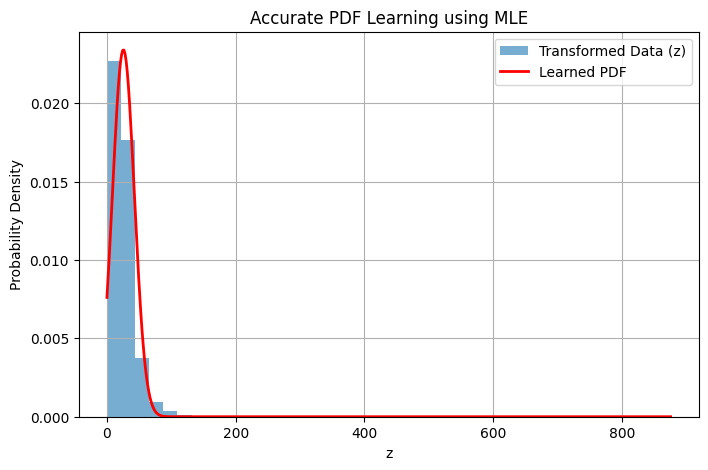

In [ ]:
# STEP 4: Visualization


z_range = np.linspace(z.min(), z.max(), 500)
pdf_estimated = c_hat * np.exp(-lambda_hat * (z_range - mu_hat) ** 2)

plt.figure(figsize=(8, 5))
plt.hist(z, bins=40, density=True, alpha=0.6, label="Transformed Data (z)")
plt.plot(z_range, pdf_estimated, 'r', linewidth=2, label="Learned PDF")
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("Accurate PDF Learning using MLE")
plt.legend()
plt.grid(True)
plt.show()